In [1]:
# Load libraries

import pandas as pd
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import numpy as np
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef

In [2]:
# Loading the training data
train_data = pd.read_csv('criminal_train.csv')

#Loading the test data
test_data = pd.read_csv('criminal_test.csv')



y=train_data.Criminal

# Dropping the 'Criminal' columm from training data
X_train = train_data.drop('Criminal',axis=1)

# Columns list in training data
columns_list = X_train.columns

In [3]:
X_train.head()

,PERID,IFATHER,NRCH17_2,IRHHSIZ2,IIHHSIZ2,IRKI17_2,IIKI17_2,IRHH65_2,IIHH65_2,PRXRETRY,...,POVERTY3,TOOLONG,TROUBUND,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP
0,25095143,4,2,4,1,3,1,1,1,99,...,2,1,2,1,1,2,2,3884.805998,40026,1
1,13005143,4,1,3,1,2,1,1,1,99,...,1,2,2,2,3,2,2,1627.108106,40015,2
2,67415143,4,1,2,1,2,1,1,1,99,...,1,2,2,2,3,2,2,4344.957980,40024,1
3,70925143,4,0,2,1,1,1,1,1,99,...,3,2,2,1,1,2,2,792.521931,40027,1
4,75235143,1,0,6,1,4,1,1,1,99,...,1,2,2,2,2,2,2,1518.118526,40001,2


**Checking Missing Values and Categorical Data

In [4]:
# Check if columns had any missing values
columns_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# Columns does not have any missing values
print(columns_with_missing)

# Check if training file has any categorical data
non_categorical_predictors = X_train.select_dtypes(include=['object'])
print(non_categorical_predictors)

[]
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[45718 rows x 0 columns]


There are 3 things that took my attention :
1) There is an PERID that cannot be used for classificaiton.
2) Criminal is our class label.
3) 99.9% users deliberately leave this 'HLCALLFG','HLCALL99' features blank,so we do not need it.

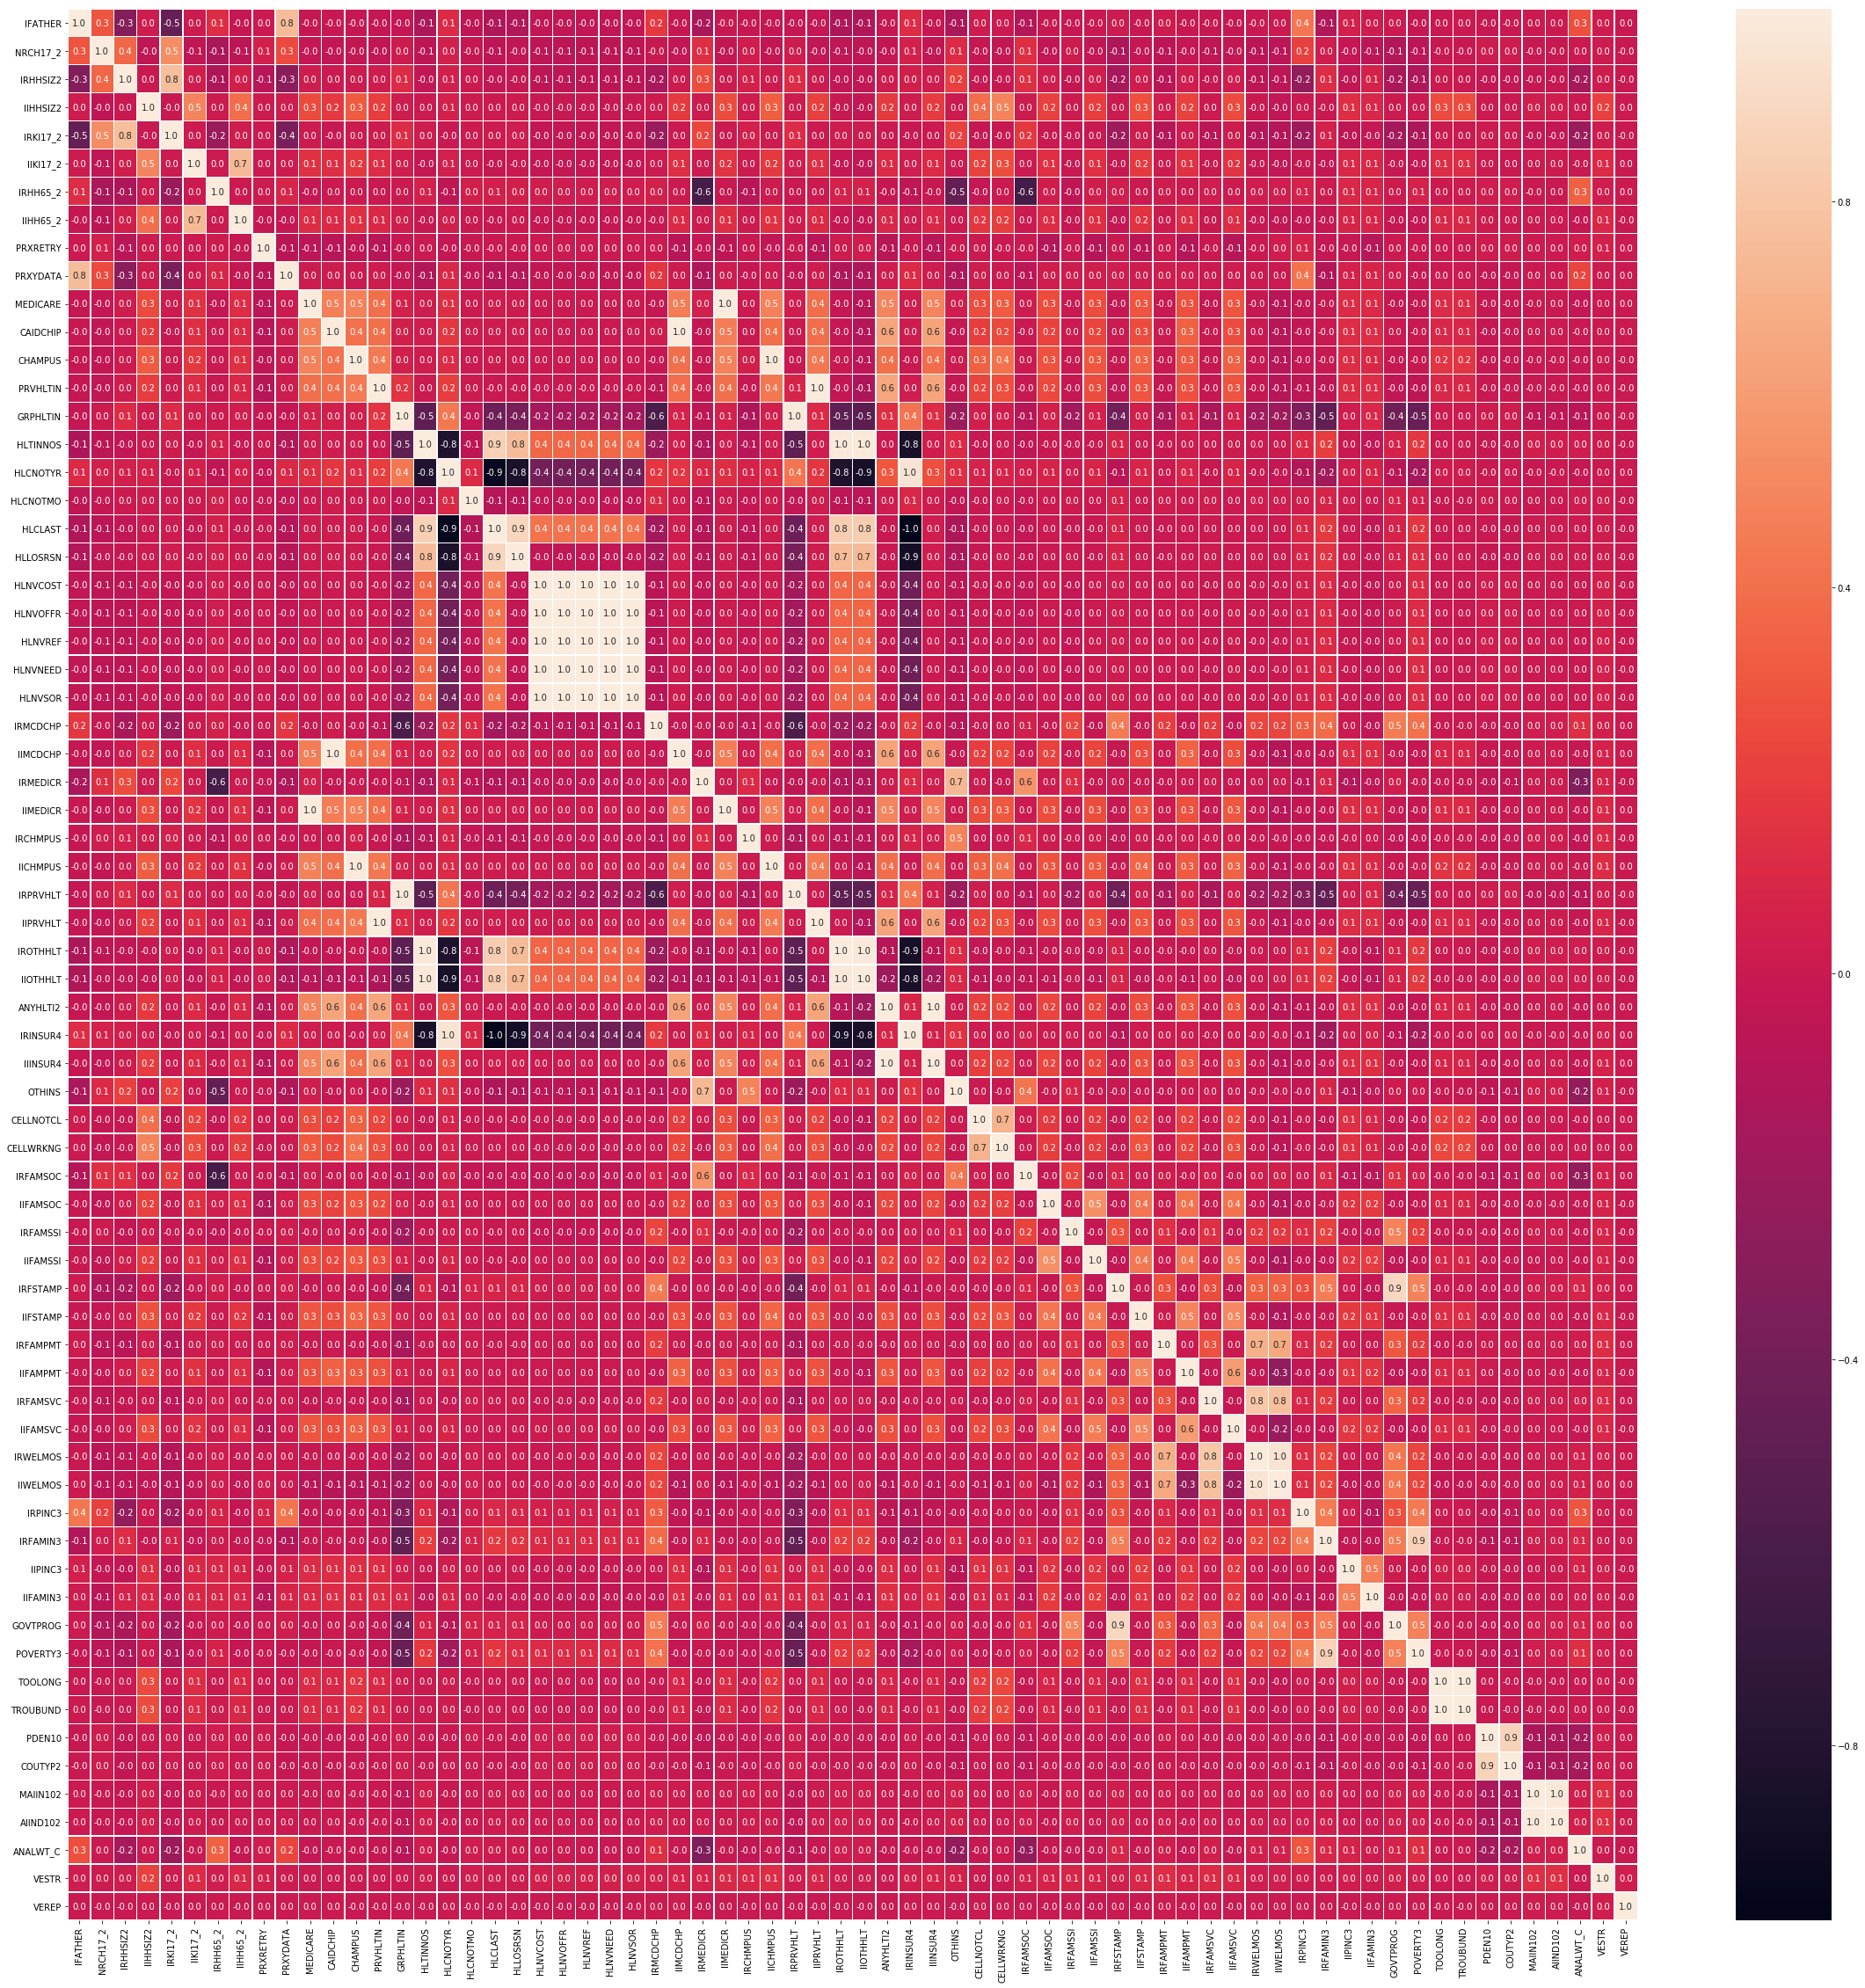

In [5]:
drop_columns=['HLCALLFG','HLCALL99','PERID']

X_train = train_data.drop(['Criminal']+drop_columns,axis=1)
X_test = test_data.drop(drop_columns,axis=1)
#correlation map
f,ax = plt.subplots(figsize=(40,40))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Criminal:  42543
Not Criminal :  3175


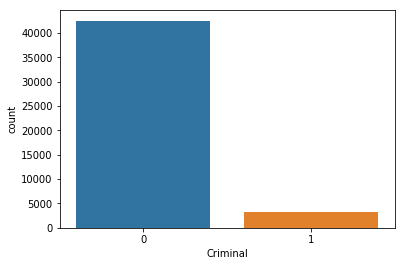

In [6]:
ax = sns.countplot(y,label="Count")       # c=42543, nc=3175
c, nc = y.value_counts()
print('Criminal: ',c)
print('Not Criminal : ',nc)

In [7]:
X_train.describe()
X_train['ANYHLTI2'].value_counts()

 1     40649
 2      4643
 94      324
 97       56
 98       44
-1         2
Name: ANYHLTI2, dtype: int64

**Data Visualization**

 4    10933
 2    10258
 3    10173
 5     6175
 6     4566
 1     3611
-1        2
Name: IRHHSIZ2, dtype: int64
 1    45675
 3       41
-1        2
Name: IIHHSIZ2, dtype: int64
 1    19258
 2    10126
 3     9554
 4     6778
-1        2
Name: IRKI17_2, dtype: int64
 1    45544
 3      172
-1        2
Name: IIKI17_2, dtype: int64
 1    45443
 3      235
 2       38
-1        2
Name: IIHH65_2, dtype: int64
 1     27827
 2     17567
 94      252
 97       44
 98       22
 85        4
-1         2
Name: PRVHLTIN, dtype: int64
 1     24551
 99    17567
 2      3205
 98      275
 94       70
 97       45
 85        3
-1         2
Name: GRPHLTIN, dtype: int64
 1    45278
 3      438
-1        2
Name: IIMCDCHP, dtype: int64
 2    41915
 1     3801
-1        2
Name: IRMEDICR, dtype: int64
 1    45492
 3      224
-1        2
Name: IIMEDICR, dtype: int64
 1    45587
 3      129
-1        2
Name: IICHMPUS, dtype: int64
 1    27998
 2    17718
-1        2
Name: IRPRVHLT, dtype: int64
 1    45394
 

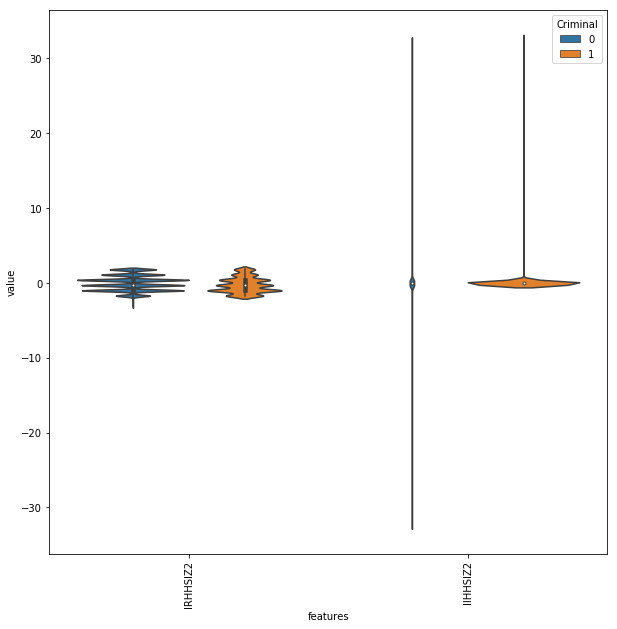

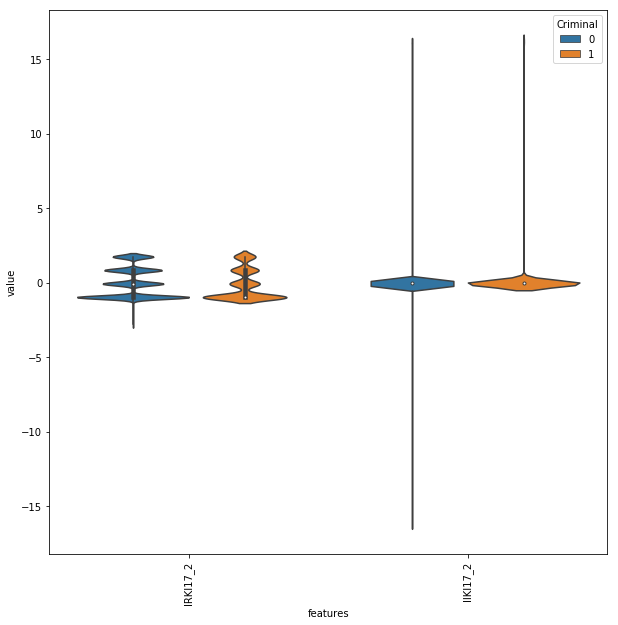

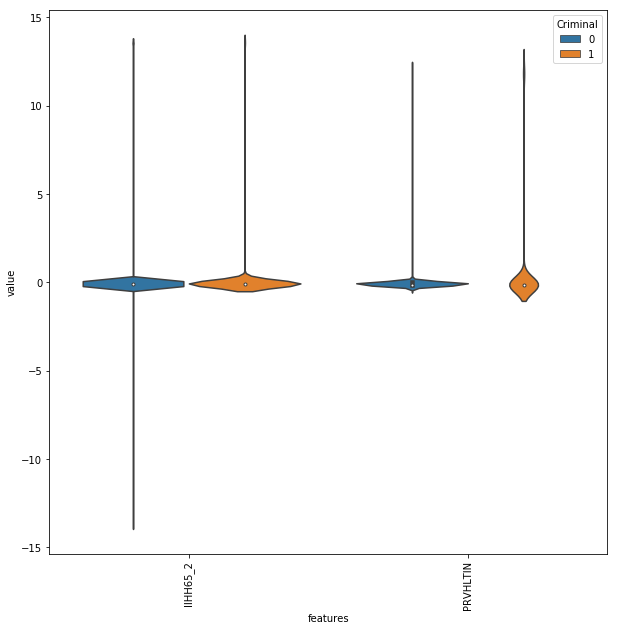

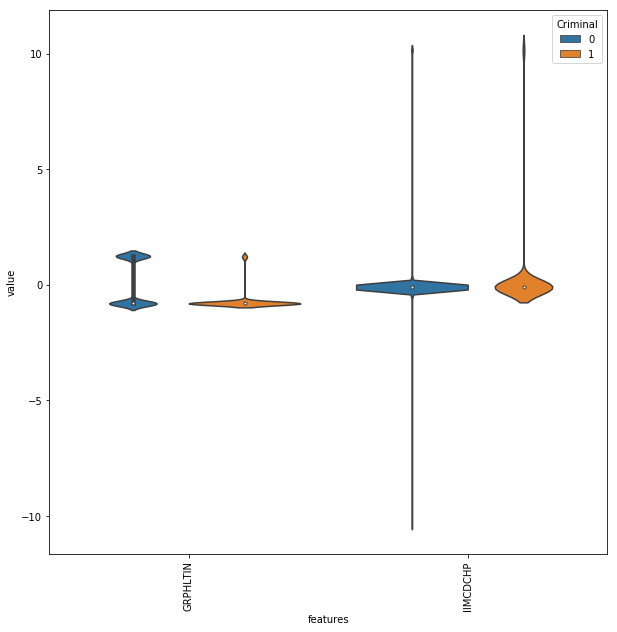

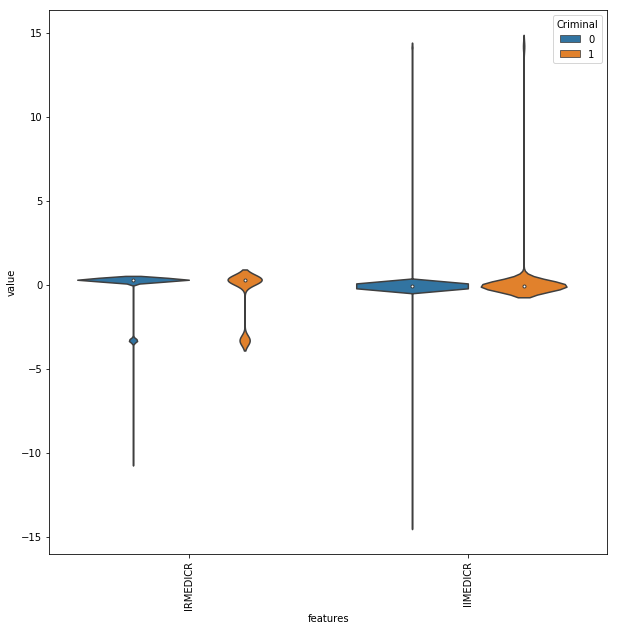

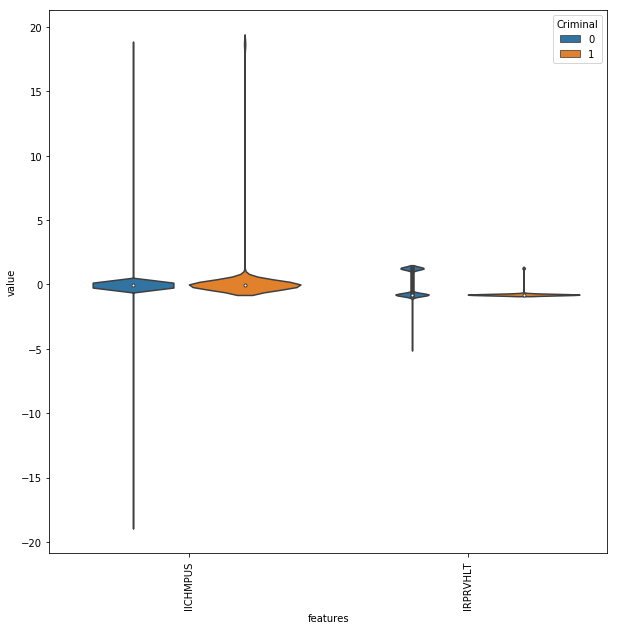

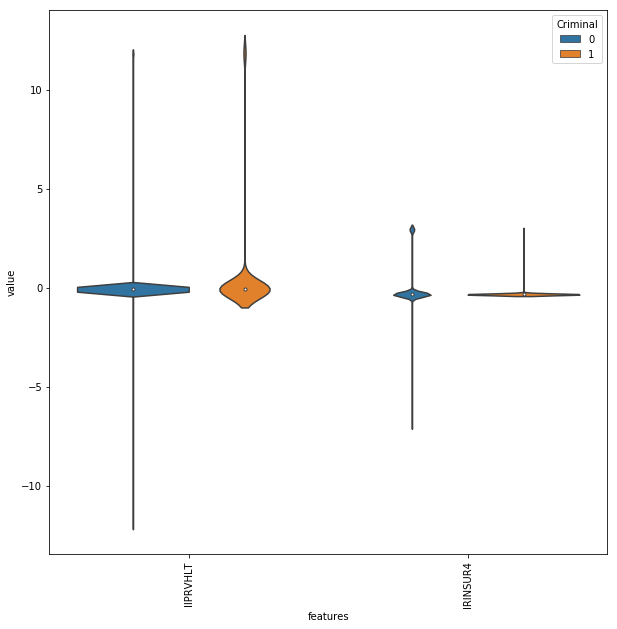

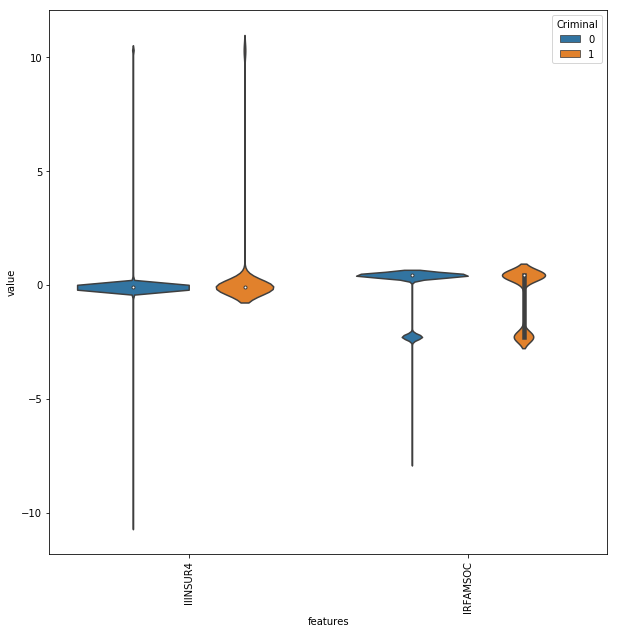

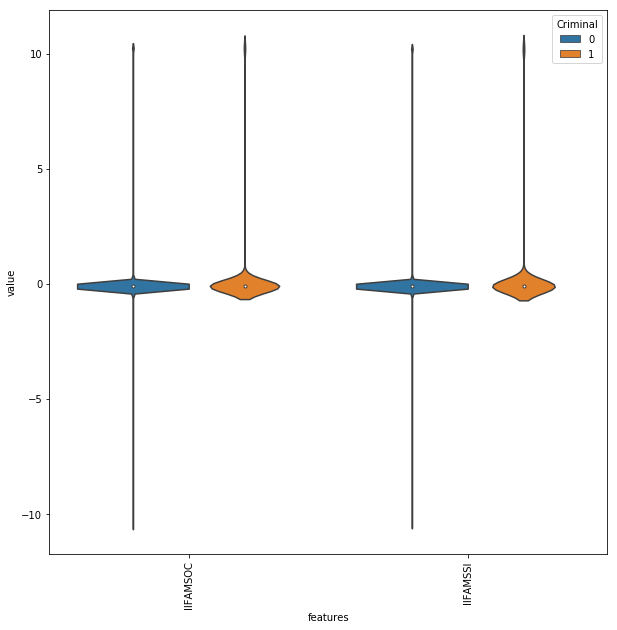

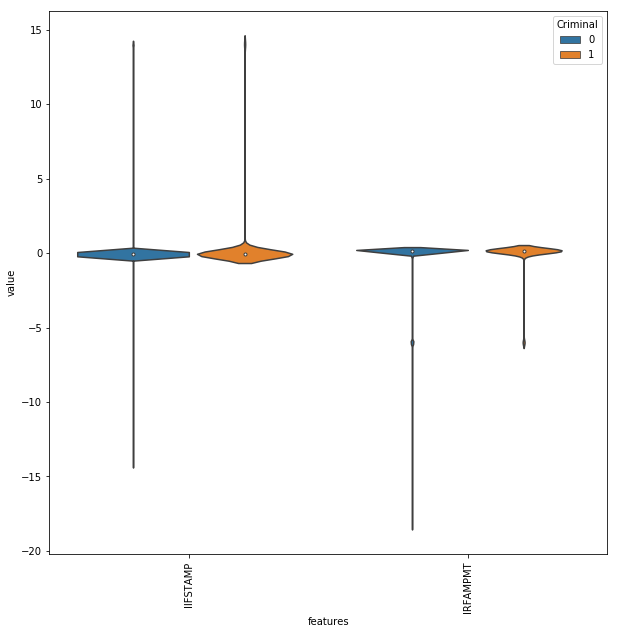

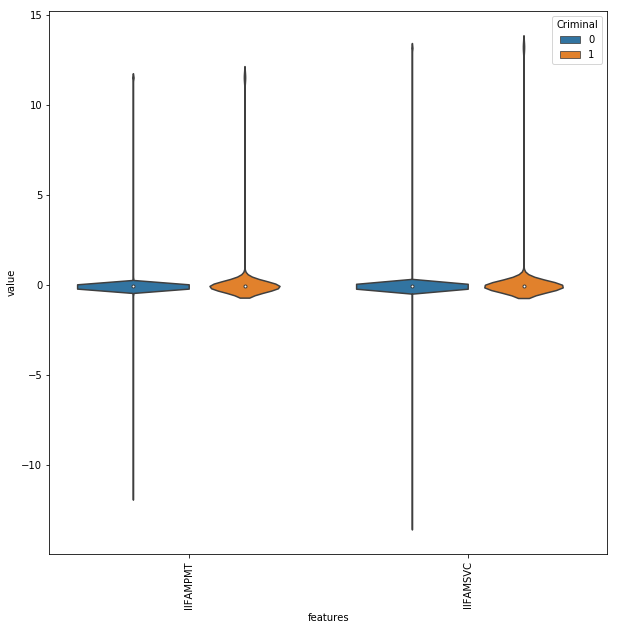

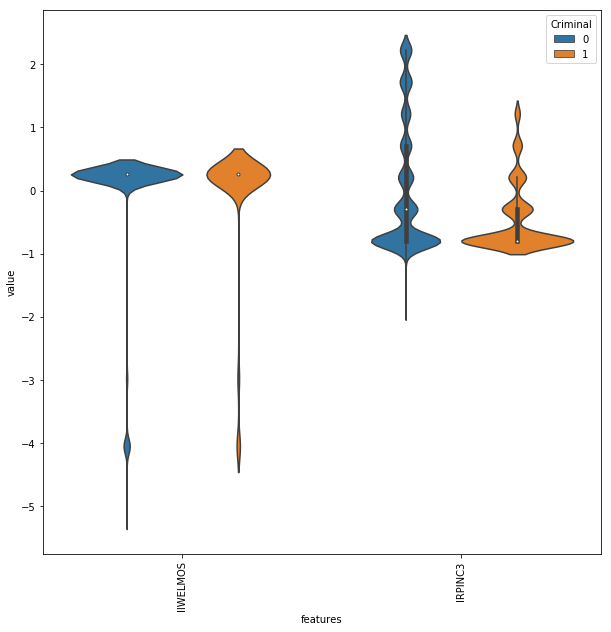

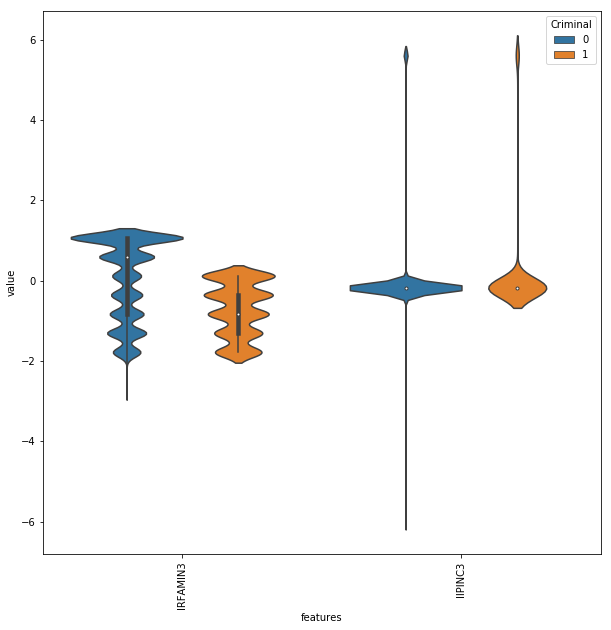

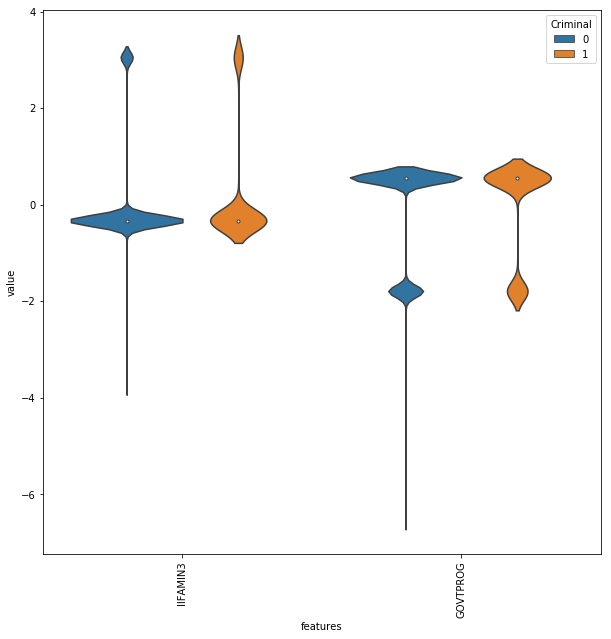

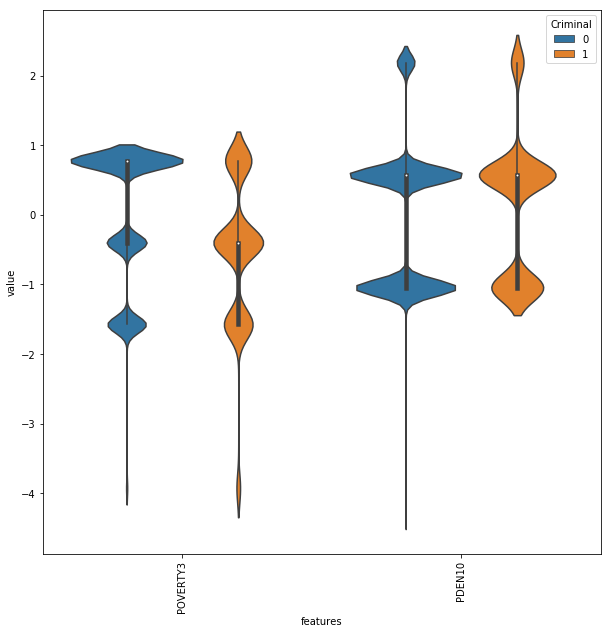

In [8]:
# first ten features
data_dia = y
COL = ['IRHHSIZ2', 'IIHHSIZ2', 'IRKI17_2', 'IIKI17_2', 'IIHH65_2',
       'PRVHLTIN', 'GRPHLTIN', 'IIMCDCHP', 'IRMEDICR', 'IIMEDICR', 'IICHMPUS',
       'IRPRVHLT', 'IIPRVHLT', 'IRINSUR4', 'IIINSUR4', 'IRFAMSOC', 'IIFAMSOC',
       'IIFAMSSI', 'IIFSTAMP', 'IRFAMPMT', 'IIFAMPMT', 'IIFAMSVC', 'IIWELMOS',
       'IRPINC3', 'IRFAMIN3', 'IIPINC3', 'IIFAMIN3', 'GOVTPROG', 'POVERTY3',
       'PDEN10']
data = X_train[COL]
data_n_2 = (data - data.mean()) / (data.std())     
# standardization
for i in range(0,len(data.columns),2):
    data = pd.concat([y,data_n_2.iloc[:,i:i+2]],axis=1)
    data = pd.melt(data,id_vars="Criminal",
                        var_name="features",
                        value_name='value')
    plt.figure(figsize=(10,10))
    sns.violinplot(x="features", y="value", hue="Criminal", data=data)
    plt.xticks(rotation=90)
for i in COL:
    print(X_train[i].value_counts())
    '''
sns.set(style="whitegrid", palette="muted")
data_dia = y
data = X_train[COL]
import time
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="Criminal",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
tic = time.time()
sns.swarmplot(x="features", y="value", hue="Criminal", data=data)
plt.xticks(rotation=90)
'''

In [9]:
drop_column = ['PRXRETRY','PRXYDATA','HLCNOTYR','HLCNOTMO','IRCHMPUS','CELLNOTCL','OTHINS','IRFSTAMP','CAIDCHIP','TOOLONG',
     'CELLWRKNG','IRFAMSSI','IRFAMSVC','ANALWT_C','IRHH65_2','HLTINNOS','HLCLAST','MEDICARE','VEREP','IFATHER','NRCH17_2',
               'CHAMPUS','VESTR','MAIIN102','IROTHHLT','IRMCDCHP','HLLOSRSN','HLNVSOR','IRFAMSOC']


In [10]:
# Features in drop_columns list does not looks like separated so it does not gives good information for classification.
#So we drop them.

X_train = X_train.drop(drop_column,axis=1)
X_test = X_test.drop(drop_column,axis=1)

In [11]:
common_columns =['HLNVCOST','HLNVOFFR','HLNVREF','HLNVNEED','HLNVSOR','IIOTHHLT','IROTHHLT','TROUBUND','MAIIN102',
                'AIIND102','IIWELMOS','IRWELMOS','PDEN10','COUTYP2','ANYHLTI2','IIINSUR4']

# variables in the common_columns looks similar for confiramtion we will check heat map

#correlation map
#f,ax = plt.subplots(figsize=(15,15))
#sns.heatmap(X_train[common_columns].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

# The values in the correlation map looks same so we are considering only feature and dropping others.

X_train=X_train.drop(['HLNVCOST','HLNVOFFR','HLNVREF','HLNVNEED','IIOTHHLT',
                      'ANYHLTI2','TROUBUND','AIIND102','IRWELMOS','COUTYP2'],axis=1)
X_test=X_test.drop(['HLNVCOST','HLNVOFFR','HLNVREF','HLNVNEED','IIOTHHLT','TROUBUND',
                    'ANYHLTI2','AIIND102','IRWELMOS','COUTYP2'],axis=1)

**Train the model and predict accuracy**

In [12]:
# using recursive-feature elimination with cross-validation to get the the best features
from sklearn.feature_selection import RFECV
estimator = GradientBoostingClassifier()
selector = RFECV(estimator, step=1, cv=7)
selector = selector.fit(X_train, y)
selector.support_ 
selector.ranking_

array([ 1, 15,  1, 14,  8,  1,  1,  1,  1, 16, 11,  1,  6,  3,  7, 13,  2,
       17,  5, 12, 10,  9,  1,  1, 18,  1,  4,  1,  1])

In [13]:
selector.n_features_
X_train.columns[selector.support_]


Index(['IRHHSIZ2', 'IRKI17_2', 'PRVHLTIN', 'GRPHLTIN', 'IIMCDCHP', 'IRMEDICR',
       'IRPRVHLT', 'IRPINC3', 'IRFAMIN3', 'IIFAMIN3', 'POVERTY3', 'PDEN10'],
      dtype='object')

In [15]:
selected_features = ['GRPHLTIN', 'IRHHSIZ2','IIMEDICR', 'IRMEDICR', 'IICHMPUS',
               'IRPRVHLT','IIPRVHLT','IIFAMSSI',  'IIINSUR4', 'IIFAMSOC','GOVTPROG',               
               'IIWELMOS','IRFAMIN3', 'IIFAMIN3','IRPINC3','IIPINC3','PDEN10']

X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X_train, y, test_size=.25)
model = GradientBoostingClassifier() 
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)  

0.61698072075407495

**Tuning our model**

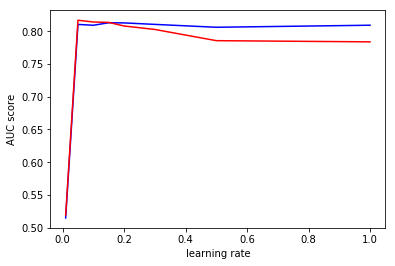

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
learning_rates = []
train_results = []
test_results = []
for var in [0.01,0.05,0.1,0.15,0.2,0.3,0.5,1]:
    #eta=var/1000
    learning_rates.append(var)
    model = GradientBoostingClassifier(learning_rate=var)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
plt.plot(learning_rates, train_results, 'b', label="Train AUC")
plt.plot(learning_rates, test_results, 'r', label="Test AUC")
plt.ylabel("AUC score")
plt.xlabel("learning rate")
plt.show()

# We see that using a dataset is overfitting for large learning rates. For this data, a learning rate of 0.1 is optimal.

In [18]:
print(test_results)
print(train_results)
print(learning_rates)

[0.51924444158703731, 0.81680443227647848, 0.81411063515467996, 0.81348719375817125, 0.8080173578098413, 0.80273570402184213, 0.78563201048939568, 0.78380873183995226]
[0.51498811733838679, 0.81044012491302653, 0.80913208474443454, 0.81298741871169455, 0.81273130620678524, 0.8104707847349738, 0.80608211246965467, 0.80919725997317327]
[0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1]


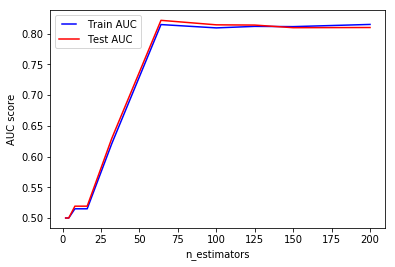

In [19]:
n_estimators = []
train_results = []
test_results = []
for estimator in [2,4,8,16,32,64,100,125,150,200]:
    n_estimators.append(estimator)
    model = GradientBoostingClassifier(n_estimators=estimator)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()
# 1, 2, 4, 8, 16, 32, 64, 100,128,150
#Increasing the number of estimators may result in overfitting also. In this case, using 100 (default) trees is optimal.

In [20]:
print(test_results)
print(train_results)
print(n_estimators)

[0.5, 0.5, 0.51924444158703731, 0.51924444158703731, 0.62946463348591253, 0.82141559912788598, 0.81411063515467996, 0.81372242145858531, 0.80945242276318996, 0.80974654537911894]
[0.5, 0.5, 0.51498811733838679, 0.51498811733838679, 0.62092645082389686, 0.81453590477075144, 0.80913208474443454, 0.81159082553023032, 0.81119371349531944, 0.81476001063982972]
[2, 4, 8, 16, 32, 64, 100, 125, 150, 200]


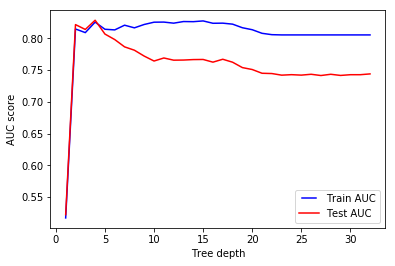

In [21]:
import numpy as np

max_depths = np.linspace(1,32,32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

# We see that our model overfits for large depth values. The tree perfectly predicts all of the train data.
# However, it fails to generalize the findings for new data. We are taking tree depths as default.

In [22]:
print(test_results)
print(train_results)
print(max_depths)

[0.52236164856958101, 0.8217567672838979, 0.81411063515467996, 0.8286146226454939, 0.80686456609698942, 0.79815973333508528, 0.78669071112208189, 0.78140905733408295, 0.77213967809118533, 0.76437610809258372, 0.76917545710432245, 0.76571708196576682, 0.76591711350153036, 0.76664649535363683, 0.76683467751396817, 0.76261172435865543, 0.76717584566998021, 0.76251763327848976, 0.75402468142778156, 0.75100156552540365, 0.74509647034089599, 0.74466121110471839, 0.74212039997860069, 0.74288497799535791, 0.74216744551868352, 0.74350841939186663, 0.7415440041221748, 0.74350841939186663, 0.74168514074242309, 0.74283793245527496, 0.74283793245527496, 0.74408481524829251]
[0.51725885875084721, 0.81487035034788402, 0.80913208474443454, 0.82560375718820656, 0.81442011838890149, 0.81341133498370854, 0.82082048165893673, 0.81664955090689084, 0.8219586978395983, 0.82554929045025116, 0.82570595659469737, 0.8240132888277365, 0.82656443821124892, 0.82636940107516677, 0.82753962389165969, 0.82383391830609

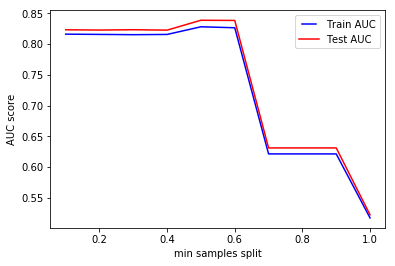

In [23]:
min_samples_splits = np.linspace(0.1,1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    model = GradientBoostingClassifier(min_samples_split=min_samples_split)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()
# We can clearly see that when we require all of the samples at each node, the model cannot learn enough about the data. 
# This is an overfitting case.

In [24]:
print(test_results)
print(train_results)
print(min_samples_splits)

[0.82339186377300999, 0.82295660453683261, 0.82348595485317566, 0.82281546791658411, 0.8389075063564273, 0.83856633820041548, 0.63114677551510756, 0.63114677551510756, 0.63114677551510756, 0.52236164856958101]
[0.81626694352934837, 0.81586983149443726, 0.81540846191279648, 0.8157985361849609, 0.82826365519082201, 0.82668769148772037, 0.62140189593103101, 0.62140189593103101, 0.62140189593103101, 0.51725885875084721]
[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


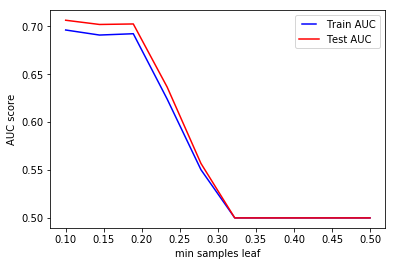

In [25]:
min_samples_leafs = np.linspace(0.1, 0.5, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

# We can clearly see that when we require all of the samples at each node, the model cannot learn enough about the data. 
# This is an overfitting case.

(34288, 17)


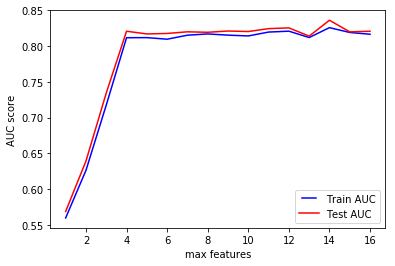

In [26]:
max_features = list(range(1,x_train.shape[1]))
print(x_train.shape)
train_results = []
test_results = []
for max_feature in max_features:
    model = GradientBoostingClassifier(max_features=max_feature)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

**Submissions**

In [27]:
my_pipeline = make_pipeline(GradientBoostingClassifier())
my_pipeline.fit(X_train, y)
predictions = my_pipeline.predict(X_test)

my_submission = pd.DataFrame({'PERID': test_data.PERID, 'Criminal': predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False,columns= ['PERID','Criminal'])   
#.80215